In [1]:
import numpy as np
import astropy as ap
from astropy import units as u
import matplotlib.pyplot as plt
import ugradio
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Functions to Use

    ifm.stow
    ifm.maintenance
    ifm.get_pointing where is telescope now
    ifm.point(alt,az) where do you want it to point
    hpm.read_voltage
    hpm.start_recording(dt)
    hpm.get_recording_data()
    hpm.end_recording()
    ugradio.coord.sunpos(jd)
    ugradio.coord.moonpos(jd,lat,lon,alt)
    ugradio.coord.get_altaz(ra, dec, jd, lat, lon, alt)
    ugradio.coord.precess(ra, dec, jd, equinox)

In [2]:
ifm = ugradio.interf.Interferometer()
hpm = ugradio.hp_multi.HP_Multimeter()


In [3]:
# Crab Nebula
print('Crab Nebula coordinates are {}'.format(ap.coordinates.SkyCoord('05:34:31.95', '+22:00:52.1', unit = (u.hourangle, u.deg))))

# Orion Nebula
print('Orion Nebula coordinates are {}'.format(ap.coordinates.SkyCoord('05:35:17.3', '-05:23:28', unit = (u.hourangle, u.deg))))

# M17
print('M17 coordinates are {}'.format(ap.coordinates.SkyCoord('18:20:26', '-16:10.6', unit = (u.hourangle, u.deg))))

# Cygnus A 
print('CygA coordinates are {}'.format(ap.coordinates.SkyCoord('19:59:28.357', '+40:44:02.1', unit = (u.hourangle, u.deg))))

# Cas A
print('Cas A coordinates {}'.format(ap.coordinates.SkyCoord('23:23:24', '+58:48.9', unit = (u.hourangle, u.deg))))

Crab Nebula coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.633125,  22.01447222)>
Orion Nebula coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.82208333, -5.39111111)>
M17 coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 275.10833333, -16.17666667)>
CygA coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 299.86815417,  40.73391667)>
Cas A coordinates <SkyCoord (ICRS): (ra, dec) in deg
    ( 350.85,  58.815)>


In [4]:
def julianDayArray(hrs, dt, initUnixT):
    interval = hrs*60./dt
    secInt = dt*60.
    jds = []
    for i in range(int(interval)):
        jds.append(ugradio.timing.julian_date(initUnixT + secInt*i))
    # actual julian data to put into alt az functions
    jds = np.array(jds)
    # start from 0 and convert to hours for plot
    jdHrs = []
    jdHrs = (jds - jds[0])*24
    return jds, np.array(jdHrs)

In [5]:
def findAltAz(ra, dec, jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raP, decP = ugradio.coord.precess(ra, dec, jd = j)
        alt, az = ugradio.coord.get_altaz(raP, decP, jd =j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [6]:
def moonAltAz(jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raM,decM = ugradio.coord.moonpos(jd = j)
        alt, az = ugradio.coord.get_altaz(raM, decM, jd = j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [7]:
def sunAltAz(jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raS, decS = ugradio.coord.sunpos(jd = j)
        alt, az = ugradio.coord.get_altaz(raS, decS, jd = j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [8]:
def corrections(altitude, azimuth):
    for al, az, i in zip(altitude, azimuth, range(len(altitude))):
        if az < 90:
            azimuth[i] = az + 180
            altitude[i] = abs(180 - altitude[i])
        elif az > 300:
            azimuth[i] = az - 180
            altitude[i] = abs(180 - altitude[i])
    return altitude, azimuth

In [16]:
def collect_data(ra, dec, hrs, dt, n, dataFile):
    
    unix = ugradio.timing.unix_time()
    jds, jdsHr = julianDayArray(hrs, dt, unix)
    alts, azs = findAltAz(ra, dec, jds)
    correctAlt, correctAz = corrections(alts, azs)
    
    ct = 0
    for al, az in zip(correctAlt, correctAz):
        ifm.point(al, az)
        get_point = ifm.get_pointing()
        valAltAz = get_point.values()
        print('{}\t{}\t{}\t{}\n'.format(valAltAz[0][0], valAltAz[0][1], valAltAz[1][0], valAltAz[1][1]))
        
        hpm.start_recording(n)
        start_time = time.time()
        time.sleep(dt*60)
        current_time = time.time()
        if current_time - start_time >= dt*60:
            volts, times = hpm.end_recording()
            np.savez('{}_{}'.format(dataFile, ct), v = volts, tt = times)   
            ct += 1

In [17]:
collect_data(350.85,  58.815,10,15,.5,'CasA')

146.27734375	218.326855469	146.140136719	218.301757812

144.365722656	219.029980469	144.31640625	218.982910156

142.476074219	219.645214844	142.316894531	219.598144531

140.542480469	220.106640625	140.493164062	220.081542969

138.630859375	220.480175781	138.581542969	220.455078125

136.719238281	220.743847656	136.691894531	220.71875

134.785644531	220.831738281	134.758300781	220.850585938

132.874023438	220.809765625	132.780761719	220.828613281

130.918457031	220.612011719	130.847167969	220.608886719

128.984863281	220.238476562	128.891601562	220.235351562

127.051269531	219.645214844	127.045898438	219.642089844

125.18359375	218.78828125	125.15625	218.807128906

123.337890625	217.667675781	123.354492188	217.686523438

121.558105469	216.261425781	121.596679688	216.258300781

119.822265625	214.481640625	119.794921875	214.456542969

118.174316406	212.328320312	118.190917969	212.347167969

116.680175781	209.779492188	116.674804688	209.710449219

115.273925781	206.681347656	115.224609375	2

In [21]:
def collect_data_sun(hrs, dt, n, dataFile):
    
    unix = ugradio.timing.unix_time()
    jds, jdsHr = julianDayArray(hrs, dt, unix)
    alts, azs = sunAltAz(jds)
    correctAlt, correctAz = corrections(alts, azs)
    
    ct = 0
    for al, az in zip(correctAlt, correctAz):
        ifm.point(al, az)
        get_point = ifm.get_pointing()
        valAltAz = get_point.values()
        print('{}\t{}\t{}\t{}\n'.format(valAltAz[0][0], valAltAz[0][1], valAltAz[1][0], valAltAz[1][1]))
        
        hpm.start_recording(n)
        start_time = time.time()
        time.sleep(dt*60)
        current_time = time.time()
        if current_time - start_time >= dt*60:
            volts, times = hpm.end_recording()
            np.savez('{}_{}'.format(dataFile, ct), v = volts, tt = times)   
            ct += 1

In [22]:
collect_data_sun(1./6,1,0.5,'Sun_test')

8.4208984375	253.570996094	8.37158203125	255.040039062

8.2890625	255.5265625	8.26171875	255.501464844

8.09130859375	255.680371094	8.0419921875	255.69921875

7.87158203125	255.856152344	7.8662109375	255.853027344

7.7177734375	256.009960938	7.66845703125	256.006835938

7.498046875	256.163769531	7.49267578125	256.160644531

7.322265625	256.339550781	7.294921875	256.336425781

7.1025390625	256.493359375	7.119140625	256.490234375

6.9267578125	256.647167969	6.8994140625	256.644042969

6.7509765625	256.800976562	6.70166015625	256.797851562



In [11]:
# Julian day times for 24 hours at 15 minute intervals starting March 4th at 3 am
jd_times, jd_72hrs = julianDayArray(20, 15, ugradio.timing.unix_time())
# jd_moon, jd_24moon = julianDayArray(24, 3, 1520166599.7119844)

In [13]:
# Find Coordinates for Objects of Interest
crabAlt, crabAz = findAltAz(83.633125,  22.01447222, jd_times)
orionAlt, orionAz = findAltAz(83.82208333, -5.39111111, jd_times)
M17Alt, M17Az = findAltAz(275.10833333, -16.17666667, jd_times)
CygAlt, CybAz = findAltAz(299.86815417,  40.73391667, jd_times)
CasAlt, CasAz = findAltAz(350.85,  58.815, jd_times)
# moonAlt, moonAz = moonAltAz(jd_moon)
# sunAlt, sunAz = sunAltAz(jd_moon)

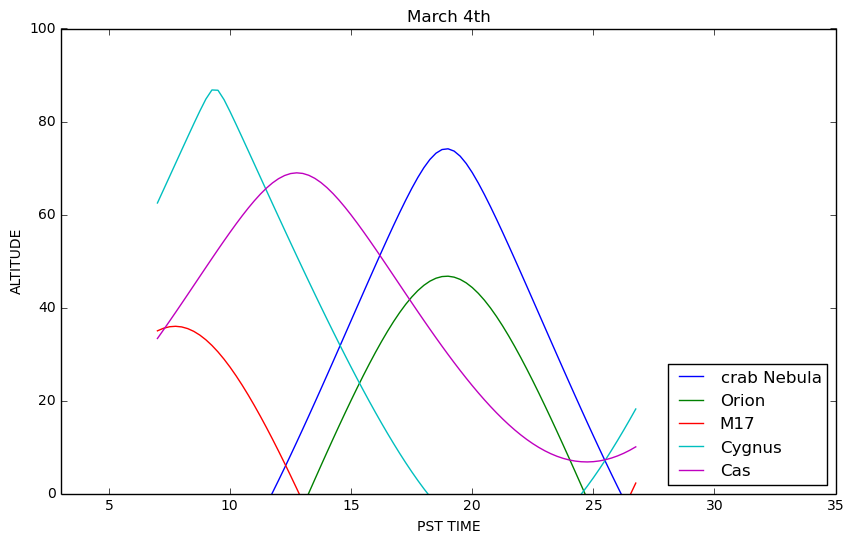

In [14]:
plt.figure(figsize = (10,6))
plt.plot(jd_72hrs+7, crabAlt, label = 'crab Nebula')
plt.plot(jd_72hrs+7, orionAlt, label = 'Orion')
plt.plot(jd_72hrs+7, M17Alt, label = 'M17')
plt.plot(jd_72hrs+7, CygAlt, label = 'Cygnus')
plt.plot(jd_72hrs+7, CasAlt, label = 'Cas')
# plt.plot(jd_24moon+3, moonAlt, label = 'Moon', c = 'navy')
# plt.plot(jd_24moon+3, sunAlt, 'y', label = 'Sun')
plt.ylim(0,100)
plt.xlim(3,35)
plt.legend(loc = 'lower right')
plt.xlabel('PST TIME')
plt.ylabel('ALTITUDE')
plt.title('March 4th')

In [ ]:
with open('{}.txt'.format('test'), 'w') as pointFile: 
    pointFile.write('{}\n{}'.format('alt', 'az'))

In [ ]:
def collect_moon_now():
    start_t = ugradio.timing.unix_time()
    moonRA, moonDEC = ugradio.coord.moonpos()
    moonALT, moonAZ = ugradio.coord.get_altaz(moonRA, moonDEC)
    ifm.point(moonALT, moonAZ)
    print('Where am I pointing?', ifm.get_pointing(), 'and where is the moon?', moonALT, moonAZ)
    hpm.start_recording(0.2)
    
    V, t = hpm.get_recording_data()

In [ ]:
print(time.time())
print(ugradio.timing.unix_time())

In [ ]:
moonRA, moonDEC = ugradio.coord.moonpos()
moonALT, moonAZ = ugradio.coord.get_altaz(moonRA, moonDEC)

In [ ]:
moonALT, moonAZ

In [ ]:
ugradio.coord.sunpos()

In [ ]:
ifm.get_pointing()

In [ ]:
ifm.point(moonALT, moonAZ)

In [ ]:
hpm.start_recording(0.3)

In [ ]:
901*.15

In [ ]:
hpm.get_recording_status()

In [ ]:
# hpm.end_recording()

In [ ]:
# V_025, t_025 = hpm.get_recording_data()

In [ ]:
# V_015, t_015 = hpm.get_recording_data()

In [ ]:
# V_005, t_005 = hpm.get_recording_data()

In [ ]:
V_01, t_01 = hpm.get_recording_data()

In [ ]:
# V_1, t_1 = hpm.get_recording_data()

In [ ]:
V_02, t_02 = hpm.get_recording_data()

In [ ]:
V_03, t_03 = hpm.get_recording_data()

In [ ]:
plt.plot(t_03, V_03)
plt.plot()

In [ ]:
plt.plot(t_025, V_025)
plt.plot()

In [ ]:
plt.plot(t_015, V_015)

In [ ]:
plt.plot(t_005, V_005)

In [ ]:
plt.plot(t_01, V_01)

In [ ]:
plt.plot(t_02,V_02)

In [ ]:
t_02

In [ ]:
plt.plot(t_1, V_1)